1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [49]:
df = pd.read_csv('data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Split des data

In [50]:
df.sex = df.sex.astype('category')
df.smoker = df.smoker.astype('category')
df.region = df.region.astype('category')

y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1137, 6)
X_test (201, 6)
y_train (1137, 6)
y_test (201, 6)


# Test entre 2 méthodes

### init

In [51]:
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso, LassoCV

from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser

set_config(transform_output = "pandas")

alphas = np.linspace(.1, 50, 20)
l1_ratios = np.linspace(0.01, 1, 20)
bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}

## Pipeline

In [75]:
pipe_bmi = make_pipeline(
    ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True),
    OneHotEncoder(variables=['bmi'])
)

transformers = make_column_transformer(
    (OneHotEncoder(variables=['region']), ['region']),
    (OrdinalEncoder(variables=['smoker', 'sex']), ['smoker', 'sex']),
    (pipe_bmi, ['bmi']),
    remainder='passthrough'
)

np.set_printoptions(threshold=np.inf)

df_preprocessor = transformers.fit_transform(X_train, y_train)
df_preprocessor.head()

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,onehotencoder__region_northeast,ordinalencoder__smoker,ordinalencoder__sex,"pipeline__bmi_(25.0, 30.0]","pipeline__bmi_(40.0, inf]","pipeline__bmi_(18.5, 25.0]","pipeline__bmi_(30.0, 40.0]","pipeline__bmi_(-0.001, 18.5]",remainder__age,remainder__children
331,1,0,0,0,1,1,1,0,0,0,0,52,0
796,0,1,0,0,0,1,0,1,0,0,0,30,2
1039,1,0,0,0,0,1,1,0,0,0,0,19,2
261,0,1,0,0,1,0,1,0,0,0,0,20,1
70,0,1,0,0,1,0,0,0,1,0,0,27,0


## GridSearchSV

### Model fit

In [53]:
from sklearn.model_selection import GridSearchCV

preprocessor = make_pipeline(
                    transformers, 
                    PolynomialFeatures(interaction_only=False), 
                    StandardScaler(), 
                    Lasso(max_iter=1000000, tol=1e-4)
                )
#print(preprocessor.get_params())
grid = GridSearchCV(preprocessor, {'lasso__alpha': alphas}, cv=3)
grid.fit(X_train, y_train)
grid.best_score_

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore
/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore
/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False

0.8582195912844792

### Sauvegarde du model

In [54]:
import pickle
model_path = 'data/model_grid.pickle'
save_comp = {
    'model': grid.best_estimator_
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

## LassoCV

### Model fit

In [78]:
pipe = make_pipeline(
            transformers,
            PolynomialFeatures(interaction_only=False), 
            MinMaxScaler(),
            LassoCV(alphas=alphas, fit_intercept=False, max_iter=1000000, cv=5)
        )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
#print(pipe.named_steps)
print('Score :', score)
print('RMSE :', mse)
print('alpha :', pipe.named_steps.lassocv.alpha_)

/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


Score : 0.8917018599586667
RMSE : 4060.826512790554
alpha : 26.363157894736844


### Sauvegarde du model

In [57]:
import pickle
model_path = 'data/model_cv.pickle'
save_comp = {
    'model': preprocessor
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

### Graph

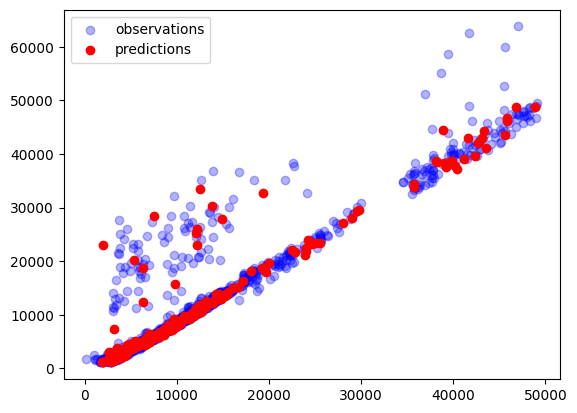

In [79]:
predictions = pipe.predict(X_test)
observations = pipe.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

# Cook distance

In [59]:
# np.set_printoptions(suppress=True)

# #create instance of influence
# influence = preprocessor.named_steps.lasso.get_influence()

# #obtain Cook's distance for each observation
# cooks = influence.cooks_distance

# #display Cook's distances
# print(cooks)

### Discrétisation de bmi pour la démo

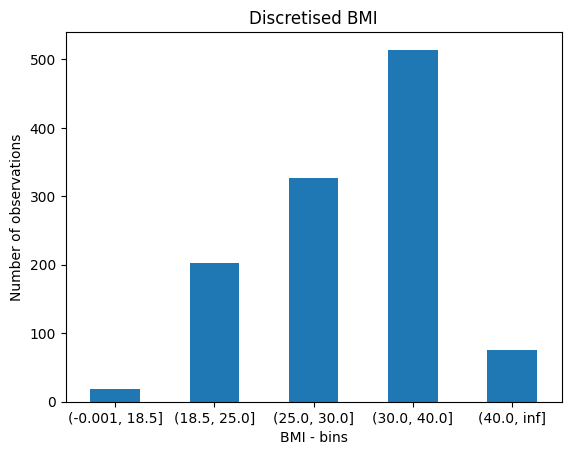

In [60]:
from feature_engine.discretisation import ArbitraryDiscretiser

bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}
transformer = ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)

bmi = transformer.fit_transform(X_train)
bmi['bmi'].value_counts(ascending=True).sort_index().plot.bar(rot=0)
plt.xlabel('BMI - bins')
plt.ylabel('Number of observations')
plt.title('Discretised BMI')
plt.show()

### chargement du model et prédiction

In [61]:
m = pickle.load(open(model_path, 'rb'))
model = m['model']

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)

# test predict sur un individu

t = pd.DataFrame([['no', 'male', 18, 15.0, 0, 'northeast']], columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region'])
model.predict(t)


AttributeError: 'MinMaxScaler' object has no attribute 'predict'

## Regression linéaire

Score : 0.8807882022217408
MSE : 4260.529293240833


/Users/maximekuil/Documents/Simplon/projet_assuraimant/.venv/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


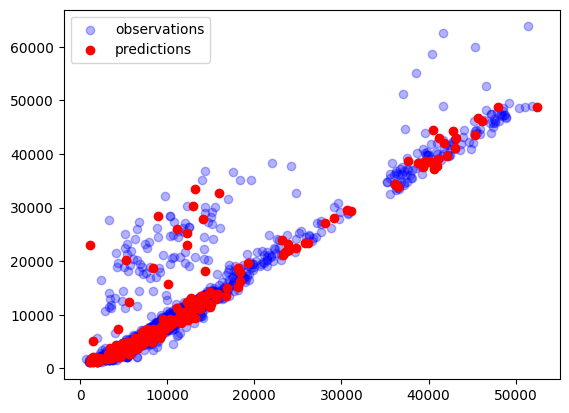

In [ ]:
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

observations = model.predict(X_train)
plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, c='r', label='predictions')
plt.legend()